In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

#Load Data




In [ ]:
import os
if os.path.isdir('./data') == False:
  !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip  
  !unzip hymenoptera_data.zip -d ./data/
  !wget https://github.com/amsadeghzadeh/amsadeghzadeh.github.io/raw/master/target.zip
  !unzip target.zip -d ./data/hymenoptera_data/

--2021-02-10 15:36:04--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.33.56, 99.86.33.48, 99.86.33.64, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.33.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  79.3MB/s    in 0.6s    

2021-02-10 15:36:05 (79.3 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: ./data/hymenoptera_data/
   creating: ./data/hymenoptera_data/train/
   creating: ./data/hymenoptera_data/train/ants/
  inflating: ./data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: ./data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: ./data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: ./data/hymenoptera_data/train/ants/1099452230_d194

#Create dataloaders

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'target': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','target']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
targetloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=False)
              for x in ['target']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','target']}
print("dataset_sizes:",dataset_sizes)
class_names = image_datasets['train'].classes
print("class_names:",class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)

dataset_sizes: {'train': 244, 'val': 153, 'target': 10}
class_names: ['ants', 'bees']
device: cuda:0


#Utils


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

#Training function


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, base_data = None, poisoned_data=None):
    since = time.time()

    for epoch in range(num_epochs):
  

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):

                if phase == 'train' and poisoned_data is not None:
                    for j,inp in enumerate(inputs):
                        if (inp == base_data).all():
                            inputs[j] = poisoned_data # The base instance is replaced with the poisoned instance
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if epoch %5==0:
              print('Epoch {}/{}'.format(epoch, num_epochs - 1))
              print('-' * 10)
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                  phase, epoch_loss, epoch_acc))

        # print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model

#Clean model, poisoned model, and fixed feature extractor are created.




In [ ]:
model_conv = models.vgg16(pretrained=True)
model_conv_poison = models.vgg16(pretrained=True)

model_conv.classifier[6] = nn.Linear(in_features=model_conv.classifier[6].in_features, out_features=2, bias=True)
for name, module in model_conv.named_modules():
    for param in module.parameters():
        param.requires_grad = False
for param in model_conv.classifier[6].parameters():
    param.requires_grad = True

model_conv_poison.classifier[6] = nn.Linear(in_features=model_conv_poison.classifier[6].in_features, out_features=2, bias=True)
for name, module in model_conv_poison.named_modules():
    for param in module.parameters():
        param.requires_grad = False
for param in model_conv_poison.classifier[6].parameters():
    param.requires_grad = True


model_conv = model_conv.to(device)
model_conv_poison = model_conv_poison.to(device)

feature_space = models.vgg16(pretrained=True)
feature_space.classifier = nn.Sequential(*list(feature_space.classifier.children())[:-2])
feature_space = feature_space.to(device)
for name, module in feature_space.named_modules():
    for param in module.parameters():
        param.requires_grad = True

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv  = optim.Adam(model_conv.parameters(), lr=0.001)
optimizer_conv_poison = optim.Adam(model_conv_poison.parameters(), lr=0.001)
# Decay LR 
exp_lr_scheduler = None
exp_lr_scheduler_poison = None

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


#Train clean model




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2114 Acc: 0.9098
val Loss: 0.1155 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.0978 Acc: 0.9549
val Loss: 0.1023 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.0578 Acc: 0.9713
val Loss: 0.1094 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.0471 Acc: 0.9836
val Loss: 0.1153 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.0305 Acc: 0.9918
val Loss: 0.1041 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.0156 Acc: 0.9959
val Loss: 0.1142 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.0198 Acc: 1.0000
val Loss: 0.1180 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.0384 Acc: 0.9877
val Loss: 0.1270 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.0141 Acc: 0.9959
val Loss: 0.1168 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.0138 Acc: 0.9959
val Loss: 0.1300 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.0099 Acc: 1.0000
val Loss: 0.1303 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.0208 Acc: 0.9877
val Loss: 0.1225 Acc: 0.9477

Ep

# Save Model

In [ ]:
torch.save({
            # 'epoch': epoch,
            'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'loss': criterion,
            }, '/content/drive/MyDrive/MlSec_HW4_Q5_clean_model')

# Load Model

In [ ]:
model_conv = models.vgg16(pretrained=True)
model_conv_poison = models.vgg16(pretrained=True)

model_conv.classifier[6] = nn.Linear(in_features=model_conv.classifier[6].in_features, out_features=2, bias=True)
for name, module in model_conv.named_modules():
    for param in module.parameters():
        param.requires_grad = False
for param in model_conv.classifier[6].parameters():
    param.requires_grad = True

model_conv = model_conv.to(device)


feature_space = models.vgg16(pretrained=True)
feature_space.classifier = nn.Sequential(*list(feature_space.classifier.children())[:-2])
feature_space = feature_space.to(device)
for name, module in feature_space.named_modules():
    for param in module.parameters():
        param.requires_grad = True

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv  = optim.Adam(model_conv.parameters(), lr=0.001)

# Decay LR 
exp_lr_scheduler = None
exp_lr_scheduler_poison = None

checkpoint = torch.load('/content/drive/MyDrive/MlSec_HW4_Q5_clean_model')
model_conv.load_state_dict(checkpoint['model_state_dict'])
optimizer_conv.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
criterion = checkpoint['loss']

model_conv.eval()
# - or -
# model.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
image_datasets['target'].targets

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

# Target and base instances are picked

In [ ]:
#The cell returns a target instance from targetloader['target'] and a base instance from dataloaders['train']. 
target_idx = [0,1,2,3,4,5,6,7,8,9]
base_idx = [243,242,241,240,233,0,1,2,3,4]
target_instances = []
target_labels = []
base_instances = []
base_labels = []
for i in range(len(target_idx)):
  target_instance = image_datasets['target'][target_idx[i]][0]
  target_label =  image_datasets['target'][target_idx[i]][1]
  base_instance = image_datasets['train'][base_idx[i]][0]
  base_label = image_datasets['train'][base_idx[i]][1]
  target_instances.append(target_instance)
  target_labels.append(target_label)
  base_instances.append(base_instance)
  base_labels.append(base_label)

#Visualize target and base instances

target_instance 0


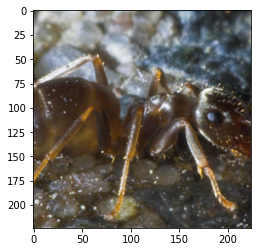

base_instance 1


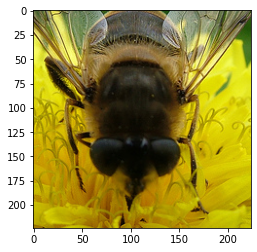

---------------------------------------------------------------
target_instance 0


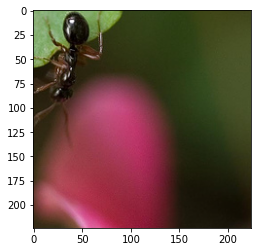

base_instance 1


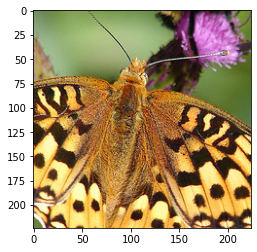

---------------------------------------------------------------
target_instance 0


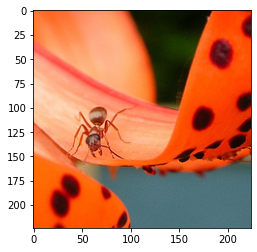

base_instance 1


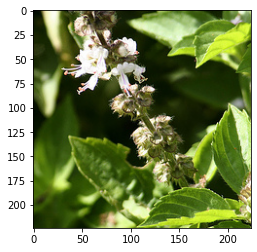

---------------------------------------------------------------
target_instance 0


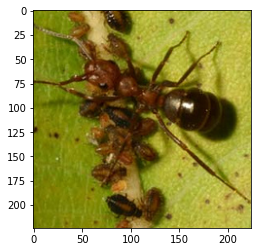

base_instance 1


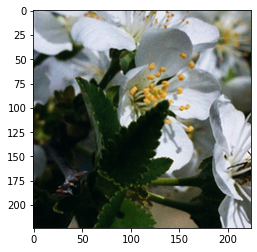

---------------------------------------------------------------
target_instance 0


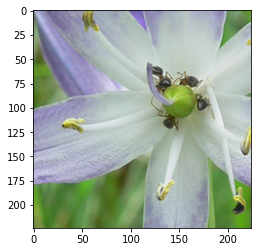

base_instance 1


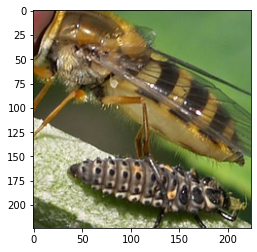

---------------------------------------------------------------
target_instance 1


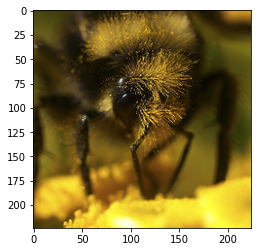

base_instance 0


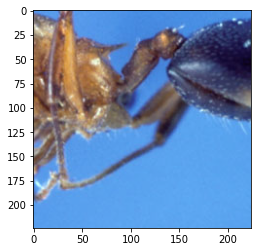

---------------------------------------------------------------
target_instance 1


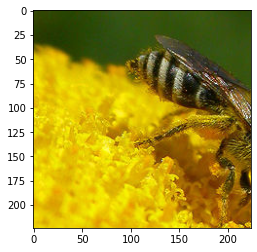

base_instance 0


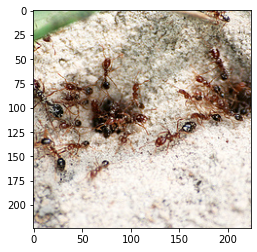

---------------------------------------------------------------
target_instance 1


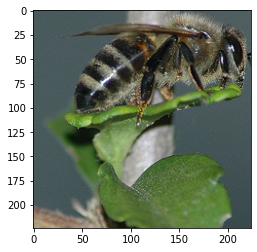

base_instance 0


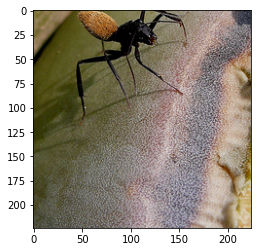

---------------------------------------------------------------
target_instance 1


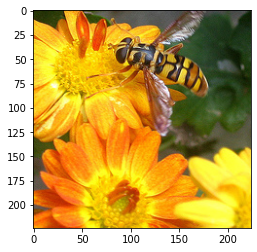

base_instance 0


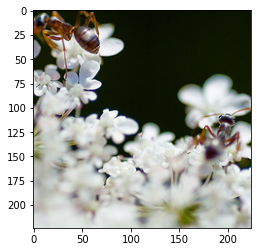

---------------------------------------------------------------
target_instance 1


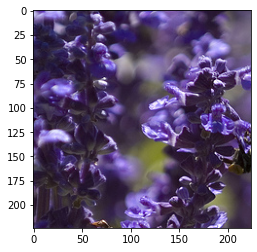

base_instance 0


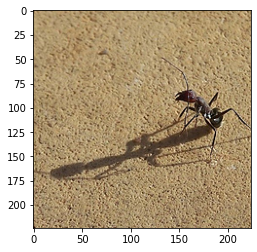

---------------------------------------------------------------


In [ ]:
for i in range(len(target_idx)):
  print("target_instance",target_labels[i])
  imshow(target_instances[i])
  print("base_instance",base_labels[i])
  imshow(base_instances[i])
  print('---------------------------------------------------------------')
  assert target_labels[i] != base_labels[i], "The labels of the target and base instances are the same!!!"

#Prediction of clean model on base and target instances 

In [ ]:
sm = nn.Softmax(dim=1)
for i in range(len(target_idx)):

  print("Target instance prediction:",np.round(sm(model_conv(target_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3))
  print("Base instance prediction:",np.round(sm(model_conv(base_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3))
  print('-------------------------------------------------')

Target instance prediction: [1. 0.]
Base instance prediction: [0. 1.]
-------------------------------------------------
Target instance prediction: [1. 0.]
Base instance prediction: [0. 1.]
-------------------------------------------------
Target instance prediction: [1. 0.]
Base instance prediction: [0. 1.]
-------------------------------------------------
Target instance prediction: [1. 0.]
Base instance prediction: [0. 1.]
-------------------------------------------------
Target instance prediction: [0.237 0.763]
Base instance prediction: [0.008 0.992]
-------------------------------------------------
Target instance prediction: [0. 1.]
Base instance prediction: [0.999 0.001]
-------------------------------------------------
Target instance prediction: [0. 1.]
Base instance prediction: [1. 0.]
-------------------------------------------------
Target instance prediction: [0.007 0.993]
Base instance prediction: [1. 0.]
-------------------------------------------------
Target instance 

In [ ]:
for i in range(len(target_idx)):
  target_instances[i] = target_instances[i].unsqueeze(0).to(device)
  base_instances[i] = base_instances[i].unsqueeze(0).to(device)

#Poison function

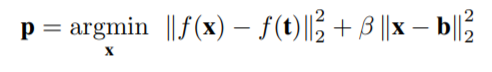

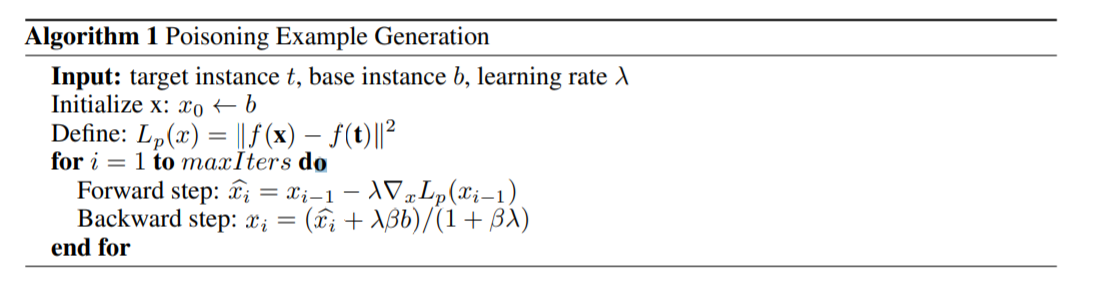![image.png]()

In [ ]:

def poison(feature_space, poisoned_instance, base_instance, target_instance, beta_0 = 0.25, lr=0.01):
    """
    base_instance b
    target_instance t
    """
    poisoned_instance.requires_grad= True
    Lp = torch.norm(feature_space(poisoned_instance)-feature_space(target_instance),2,-1).sum()
    Lp.backward()
    loss_val = poisoned_instance.grad
    poisoned_instance = poisoned_instance - loss_val
    poisoned_instance = (poisoned_instance + beta_0*lr*base_instance)/(1+beta_0*lr)
    #It needs to be completed.
    loss_val = loss_val.sum()
    return poisoned_instance, loss_val

# Running Poisoning attack for all pair with Beta = 0.25

Iteration: 0  Loss: tensor(2.8799, device='cuda:0')
Iteration: 200  Loss: tensor(1.4953, device='cuda:0')
Iteration: 400  Loss: tensor(-0.6532, device='cuda:0')
Iteration: 600  Loss: tensor(0.6536, device='cuda:0')
Iteration: 800  Loss: tensor(1.1476, device='cuda:0')
poisoned_instance


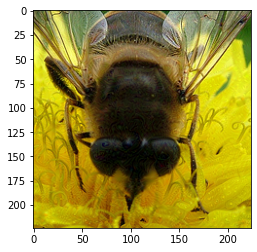

Epoch 0/24
----------
train Loss: 0.2618 Acc: 0.8770
Epoch 0/24
----------
val Loss: 0.1136 Acc: 0.9608
Epoch 5/24
----------
train Loss: 0.0295 Acc: 0.9918
Epoch 5/24
----------
val Loss: 0.1161 Acc: 0.9477
Epoch 10/24
----------
train Loss: 0.0375 Acc: 0.9795
Epoch 10/24
----------
val Loss: 0.1830 Acc: 0.9412
Epoch 15/24
----------
train Loss: 0.0156 Acc: 0.9918
Epoch 15/24
----------
val Loss: 0.1619 Acc: 0.9412
Epoch 20/24
----------
train Loss: 0.0102 Acc: 0.9959
Epoch 20/24
----------
val Loss: 0.1162 Acc: 0.9477
Training complete in 1m 42s
Clean model
Target instance prediction: [1. 0.]
Base instance prediction: [0. 1.]
Poisoned instance prediction: [1. 0.]

Poisoned model
Target instance prediction: [0.153 0.847]
Base instance prediction: [0. 1.]
Poisoned instance prediction: [0.14 0.86]

Poisoning is successful :)
Iteration: 0  Loss: tensor(-1.8625, device='cuda:0')
Iteration: 200  Loss: tensor(0.9827, device='cuda:0')
Iteration: 400  Loss: tensor(0.2913, device='cuda:0')
Ite

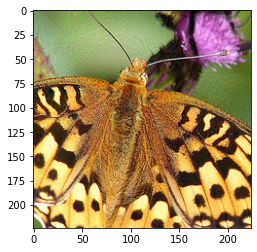

Epoch 0/24
----------
train Loss: 0.2460 Acc: 0.8852
Epoch 0/24
----------
val Loss: 0.1265 Acc: 0.9542
Epoch 5/24
----------
train Loss: 0.0371 Acc: 0.9918
Epoch 5/24
----------
val Loss: 0.1080 Acc: 0.9412
Epoch 10/24
----------
train Loss: 0.0245 Acc: 0.9918
Epoch 10/24
----------
val Loss: 0.1515 Acc: 0.9542
Epoch 15/24
----------
train Loss: 0.0162 Acc: 0.9959
Epoch 15/24
----------
val Loss: 0.1956 Acc: 0.9216
Epoch 20/24
----------
train Loss: 0.0176 Acc: 0.9918
Epoch 20/24
----------
val Loss: 0.1479 Acc: 0.9412
Training complete in 1m 42s
Clean model
Target instance prediction: [1. 0.]
Base instance prediction: [0. 1.]
Poisoned instance prediction: [1. 0.]

Poisoned model
Target instance prediction: [0.03 0.97]
Base instance prediction: [0. 1.]
Poisoned instance prediction: [0.031 0.969]

Poisoning is successful :)
Iteration: 0  Loss: tensor(2.9224, device='cuda:0')
Iteration: 200  Loss: tensor(2.3360, device='cuda:0')
Iteration: 400  Loss: tensor(-1.0496, device='cuda:0')
Ite

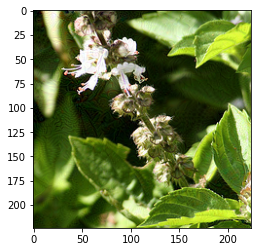

Epoch 0/24
----------
train Loss: 0.2519 Acc: 0.8852
Epoch 0/24
----------
val Loss: 0.1647 Acc: 0.9542
Epoch 5/24
----------
train Loss: 0.0204 Acc: 1.0000
Epoch 5/24
----------
val Loss: 0.1926 Acc: 0.9412
Epoch 10/24
----------
train Loss: 0.0284 Acc: 0.9795
Epoch 10/24
----------
val Loss: 0.2162 Acc: 0.9281
Epoch 15/24
----------
train Loss: 0.0063 Acc: 1.0000
Epoch 15/24
----------
val Loss: 0.2328 Acc: 0.9216
Epoch 20/24
----------
train Loss: 0.0043 Acc: 1.0000
Epoch 20/24
----------
val Loss: 0.2940 Acc: 0.9216
Training complete in 1m 41s
Clean model
Target instance prediction: [1. 0.]
Base instance prediction: [0. 1.]
Poisoned instance prediction: [1. 0.]

Poisoned model
Target instance prediction: [0. 1.]
Base instance prediction: [0.113 0.887]
Poisoned instance prediction: [0. 1.]

Poisoning is successful :)
Iteration: 0  Loss: tensor(2.4200, device='cuda:0')
Iteration: 200  Loss: tensor(0.0944, device='cuda:0')
Iteration: 400  Loss: tensor(0.3669, device='cuda:0')
Iteratio

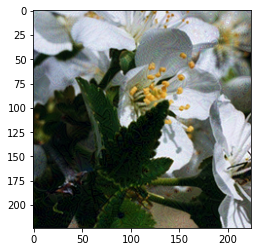

Epoch 0/24
----------
train Loss: 0.2041 Acc: 0.9180
Epoch 0/24
----------
val Loss: 0.1249 Acc: 0.9412
Epoch 5/24
----------
train Loss: 0.0350 Acc: 0.9877
Epoch 5/24
----------
val Loss: 0.1305 Acc: 0.9412
Epoch 10/24
----------
train Loss: 0.0121 Acc: 0.9959
Epoch 10/24
----------
val Loss: 0.1266 Acc: 0.9542
Epoch 15/24
----------
train Loss: 0.0161 Acc: 0.9959
Epoch 15/24
----------
val Loss: 0.1714 Acc: 0.9412
Epoch 20/24
----------
train Loss: 0.0052 Acc: 1.0000
Epoch 20/24
----------
val Loss: 0.1541 Acc: 0.9542
Training complete in 1m 41s
Clean model
Target instance prediction: [1. 0.]
Base instance prediction: [0. 1.]
Poisoned instance prediction: [1. 0.]

Poisoned model
Target instance prediction: [0.006 0.994]
Base instance prediction: [0.034 0.966]
Poisoned instance prediction: [0.011 0.989]

Poisoning is successful :)
Iteration: 0  Loss: tensor(0.4435, device='cuda:0')
Iteration: 200  Loss: tensor(0.6699, device='cuda:0')
Iteration: 400  Loss: tensor(0.7553, device='cuda:

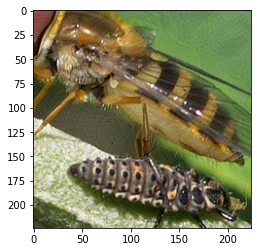

Epoch 0/24
----------
train Loss: 0.2404 Acc: 0.8934
Epoch 0/24
----------
val Loss: 0.1163 Acc: 0.9477
Epoch 5/24
----------
train Loss: 0.0213 Acc: 1.0000
Epoch 5/24
----------
val Loss: 0.1328 Acc: 0.9542
Epoch 10/24
----------
train Loss: 0.0111 Acc: 1.0000
Epoch 10/24
----------
val Loss: 0.1563 Acc: 0.9542
Epoch 15/24
----------
train Loss: 0.0111 Acc: 0.9959
Epoch 15/24
----------
val Loss: 0.1677 Acc: 0.9412
Epoch 20/24
----------
train Loss: 0.0121 Acc: 0.9959
Epoch 20/24
----------
val Loss: 0.2192 Acc: 0.9346
Training complete in 1m 41s
Clean model
Target instance prediction: [0.237 0.763]
Base instance prediction: [0.008 0.992]
Poisoned instance prediction: [0.227 0.773]

Poisoned model
Target instance prediction: [0. 1.]
Base instance prediction: [0.048 0.952]
Poisoned instance prediction: [0. 1.]

Poisoning is not successful :(
Iteration: 0  Loss: tensor(3.3901, device='cuda:0')
Iteration: 200  Loss: tensor(0.7781, device='cuda:0')
Iteration: 400  Loss: tensor(0.2895, dev

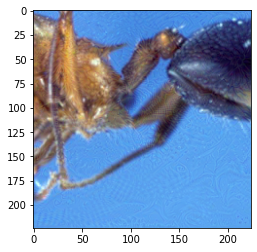

Epoch 0/24
----------
train Loss: 0.2137 Acc: 0.9180
Epoch 0/24
----------
val Loss: 0.1112 Acc: 0.9542
Epoch 5/24
----------
train Loss: 0.0515 Acc: 0.9877
Epoch 5/24
----------
val Loss: 0.1514 Acc: 0.9412
Epoch 10/24
----------
train Loss: 0.0309 Acc: 0.9877
Epoch 10/24
----------
val Loss: 0.2002 Acc: 0.9281
Epoch 15/24
----------
train Loss: 0.0087 Acc: 1.0000
Epoch 15/24
----------
val Loss: 0.1506 Acc: 0.9216
Epoch 20/24
----------
train Loss: 0.0049 Acc: 1.0000
Epoch 20/24
----------
val Loss: 0.1506 Acc: 0.9281
Training complete in 1m 41s
Clean model
Target instance prediction: [0. 1.]
Base instance prediction: [0.999 0.001]
Poisoned instance prediction: [0. 1.]

Poisoned model
Target instance prediction: [0.739 0.261]
Base instance prediction: [0.997 0.003]
Poisoned instance prediction: [0.97 0.03]

Poisoning is successful :)
Iteration: 0  Loss: tensor(-13.4191, device='cuda:0')
Iteration: 200  Loss: tensor(0.1438, device='cuda:0')
Iteration: 400  Loss: tensor(0.8112, device=

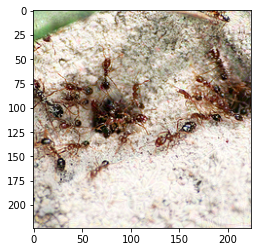

Epoch 0/24
----------
train Loss: 0.2518 Acc: 0.8934
Epoch 0/24
----------
val Loss: 0.1180 Acc: 0.9542
Epoch 5/24
----------
train Loss: 0.0350 Acc: 0.9877
Epoch 5/24
----------
val Loss: 0.1122 Acc: 0.9412
Epoch 10/24
----------
train Loss: 0.0196 Acc: 0.9959
Epoch 10/24
----------
val Loss: 0.1656 Acc: 0.9281
Epoch 15/24
----------
train Loss: 0.0130 Acc: 0.9959
Epoch 15/24
----------
val Loss: 0.1826 Acc: 0.9346
Epoch 20/24
----------
train Loss: 0.0080 Acc: 1.0000
Epoch 20/24
----------
val Loss: 0.1963 Acc: 0.9346
Training complete in 1m 41s
Clean model
Target instance prediction: [0. 1.]
Base instance prediction: [1. 0.]
Poisoned instance prediction: [0. 1.]

Poisoned model
Target instance prediction: [0.999 0.001]
Base instance prediction: [1. 0.]
Poisoned instance prediction: [0.999 0.001]

Poisoning is successful :)
Iteration: 0  Loss: tensor(-1.5838, device='cuda:0')
Iteration: 200  Loss: tensor(-0.3672, device='cuda:0')
Iteration: 400  Loss: tensor(-0.1083, device='cuda:0')

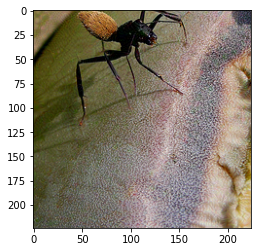

Epoch 0/24
----------
train Loss: 0.2249 Acc: 0.8852
Epoch 0/24
----------
val Loss: 0.1175 Acc: 0.9608
Epoch 5/24
----------
train Loss: 0.0536 Acc: 0.9672
Epoch 5/24
----------
val Loss: 0.1219 Acc: 0.9412
Epoch 10/24
----------
train Loss: 0.0059 Acc: 1.0000
Epoch 10/24
----------
val Loss: 0.1142 Acc: 0.9542
Epoch 15/24
----------
train Loss: 0.0090 Acc: 0.9959
Epoch 15/24
----------
val Loss: 0.1560 Acc: 0.9477
Epoch 20/24
----------
train Loss: 0.0087 Acc: 1.0000
Epoch 20/24
----------
val Loss: 0.1560 Acc: 0.9412
Training complete in 1m 41s
Clean model
Target instance prediction: [0.007 0.993]
Base instance prediction: [1. 0.]
Poisoned instance prediction: [0.065 0.935]

Poisoned model
Target instance prediction: [0.999 0.001]
Base instance prediction: [1. 0.]
Poisoned instance prediction: [0.992 0.008]

Poisoning is successful :)
Iteration: 0  Loss: tensor(-1.4262, device='cuda:0')
Iteration: 200  Loss: tensor(-0.4975, device='cuda:0')
Iteration: 400  Loss: tensor(1.1935, devic

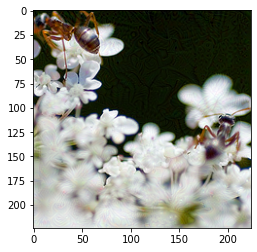

Epoch 0/24
----------
train Loss: 0.2240 Acc: 0.8934
Epoch 0/24
----------
val Loss: 0.1131 Acc: 0.9542
Epoch 5/24
----------
train Loss: 0.0488 Acc: 0.9877
Epoch 5/24
----------
val Loss: 0.1068 Acc: 0.9412
Epoch 10/24
----------
train Loss: 0.0123 Acc: 1.0000
Epoch 10/24
----------
val Loss: 0.1160 Acc: 0.9608
Epoch 15/24
----------
train Loss: 0.0095 Acc: 1.0000
Epoch 15/24
----------
val Loss: 0.1222 Acc: 0.9542
Epoch 20/24
----------
train Loss: 0.0268 Acc: 0.9918
Epoch 20/24
----------
val Loss: 0.1387 Acc: 0.9542
Training complete in 1m 41s
Clean model
Target instance prediction: [0. 1.]
Base instance prediction: [0.989 0.011]
Poisoned instance prediction: [0. 1.]

Poisoned model
Target instance prediction: [0.79 0.21]
Base instance prediction: [0.174 0.826]
Poisoned instance prediction: [0.899 0.101]

Poisoning is successful :)
Iteration: 0  Loss: tensor(-0.1346, device='cuda:0')
Iteration: 200  Loss: tensor(-0.0819, device='cuda:0')
Iteration: 400  Loss: tensor(-0.6414, device

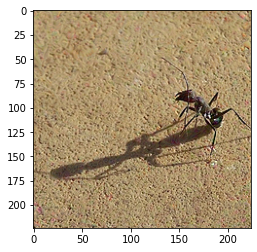

Epoch 0/24
----------
train Loss: 0.2769 Acc: 0.8648
Epoch 0/24
----------
val Loss: 0.1255 Acc: 0.9542
Epoch 5/24
----------
train Loss: 0.0351 Acc: 0.9918
Epoch 5/24
----------
val Loss: 0.1428 Acc: 0.9346
Epoch 10/24
----------
train Loss: 0.0115 Acc: 1.0000
Epoch 10/24
----------
val Loss: 0.1593 Acc: 0.9346
Epoch 15/24
----------
train Loss: 0.0147 Acc: 0.9918
Epoch 15/24
----------
val Loss: 0.1841 Acc: 0.9412
Epoch 20/24
----------
train Loss: 0.0033 Acc: 1.0000
Epoch 20/24
----------
val Loss: 0.1865 Acc: 0.9477
Training complete in 1m 41s
Clean model
Target instance prediction: [0. 1.]
Base instance prediction: [1. 0.]
Poisoned instance prediction: [0.001 0.999]

Poisoned model
Target instance prediction: [0.991 0.009]
Base instance prediction: [1. 0.]
Poisoned instance prediction: [0.985 0.015]

Poisoning is successful :)


In [ ]:
sm = nn.Softmax(dim=1)
correct = 0
for i in range(len(target_idx)):
  base_instances[i] = base_instances[i].to('cuda')
  poisoned_instance = base_instances[i].clone()
  
  for j in range(1000):
      poisoned_instance, loss = poison(feature_space, poisoned_instance.detach(), base_instances[i].clone(), target_instances[i].clone())
      if j % 200 == 0:
          print("Iteration:",j," Loss:",loss)

  poisoned_instance = poisoned_instance.to('cpu')
  base_instances[i] = base_instances[i].to('cpu')
  print("poisoned_instance")
  imshow(poisoned_instance.squeeze().detach())

  model_conv_poison = models.vgg16(pretrained=True)
  model_conv_poison.classifier[6] = nn.Linear(in_features=model_conv_poison.classifier[6].in_features, out_features=2, bias=True)
  for name, module in model_conv_poison.named_modules():
      for param in module.parameters():
          param.requires_grad = False
  for param in model_conv_poison.classifier[6].parameters():
      param.requires_grad = True
  model_conv_poison = model_conv_poison.to(device)
  optimizer_conv_poison = optim.Adam(model_conv_poison.parameters(), lr=0.001)
  # Decay LR 
  exp_lr_scheduler_poison = None


  model_conv_poison = train_model(model_conv_poison, criterion, optimizer_conv_poison,exp_lr_scheduler_poison, num_epochs=25,base_data=base_instances[i].detach(),poisoned_data = poisoned_instance.detach())
  
  target_instance_pred_clean = np.round(sm(model_conv(target_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  base_instance_pred_clean = np.round(sm(model_conv(base_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  poisoned_instance_pred_clean = np.round(sm(model_conv(poisoned_instance.reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  target_instance_pred_poisoned = np.round(sm(model_conv_poison(target_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  base_instance_pred_poisoned = np.round(sm(model_conv_poison(base_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  poisoned_instance_pred_poisoned = np.round(sm(model_conv_poison(poisoned_instance.reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)

  print("Clean model")
  print("Target instance prediction:",target_instance_pred_clean)
  print("Base instance prediction:",base_instance_pred_clean)
  print("Poisoned instance prediction:",poisoned_instance_pred_clean)
  print("\nPoisoned model")
  print("Target instance prediction:",target_instance_pred_poisoned)
  print("Base instance prediction:",base_instance_pred_poisoned)
  print("Poisoned instance prediction:",poisoned_instance_pred_poisoned)

  if np.argmax(target_instance_pred_clean) != np.argmax(target_instance_pred_poisoned):
    print("\nPoisoning is successful :)")
    correct+=1
  else:
    print("\nPoisoning is not successful :(")

  

In [ ]:
correct/10

0.9

# Running Poisoning attack for all pair with Beta = 0.5

In [ ]:
sm = nn.Softmax(dim=1)
correct = 0
for i in range(len(target_idx)):
  
  base_instances[i] = base_instances[i].to('cuda')
  poisoned_instance = base_instances[i].clone()
  for j in range(1000):
      poisoned_instance, loss = poison(feature_space, poisoned_instance.detach(), base_instances[i].clone(), target_instances[i].clone(),0.5)
      if j % 200 == 0:
          print("Iteration:",j," Loss:",loss)

  poisoned_instance = poisoned_instance.to('cpu')
  base_instances[i] = base_instances[i].to('cpu')


  model_conv_poison = models.vgg16(pretrained=True)
  model_conv_poison.classifier[6] = nn.Linear(in_features=model_conv_poison.classifier[6].in_features, out_features=2, bias=True)
  for name, module in model_conv_poison.named_modules():
      for param in module.parameters():
          param.requires_grad = False
  for param in model_conv_poison.classifier[6].parameters():
      param.requires_grad = True
  model_conv_poison = model_conv_poison.to(device)
  optimizer_conv_poison = optim.Adam(model_conv_poison.parameters(), lr=0.001)
  # Decay LR 
  exp_lr_scheduler_poison = None


  model_conv_poison = train_model(model_conv_poison, criterion, optimizer_conv_poison,exp_lr_scheduler_poison, num_epochs=25,base_data=base_instances[i].detach(),poisoned_data = poisoned_instance.detach())
  
  target_instance_pred_clean = np.round(sm(model_conv(target_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  base_instance_pred_clean = np.round(sm(model_conv(base_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  poisoned_instance_pred_clean = np.round(sm(model_conv(poisoned_instance.reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  target_instance_pred_poisoned = np.round(sm(model_conv_poison(target_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  base_instance_pred_poisoned = np.round(sm(model_conv_poison(base_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  poisoned_instance_pred_poisoned = np.round(sm(model_conv_poison(poisoned_instance.reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)

  print("Clean model")
  print("Target instance prediction:",target_instance_pred_clean)
  print("Base instance prediction:",base_instance_pred_clean)
  print("Poisoned instance prediction:",poisoned_instance_pred_clean)
  print("\nPoisoned model")
  print("Target instance prediction:",target_instance_pred_poisoned)
  print("Base instance prediction:",base_instance_pred_poisoned)
  print("Poisoned instance prediction:",poisoned_instance_pred_poisoned)

  if np.argmax(target_instance_pred_clean) != np.argmax(target_instance_pred_poisoned):
    print("\nPoisoning is successful :)")
    correct+=1
  else:
    print("\nPoisoning is not successful :(")

  

Iteration: 0  Loss: tensor(0.7538, device='cuda:0')
Iteration: 200  Loss: tensor(-0.4692, device='cuda:0')
Iteration: 400  Loss: tensor(-0.2831, device='cuda:0')
Iteration: 600  Loss: tensor(-1.6212, device='cuda:0')
Iteration: 800  Loss: tensor(1.0633, device='cuda:0')
Epoch 0/24
----------
train Loss: 0.2654 Acc: 0.8852
Epoch 0/24
----------
val Loss: 0.1109 Acc: 0.9542
Epoch 5/24
----------
train Loss: 0.0445 Acc: 0.9918
Epoch 5/24
----------
val Loss: 0.1446 Acc: 0.9346
Epoch 10/24
----------
train Loss: 0.0132 Acc: 1.0000
Epoch 10/24
----------
val Loss: 0.1243 Acc: 0.9412
Epoch 15/24
----------
train Loss: 0.0216 Acc: 0.9959
Epoch 15/24
----------
val Loss: 0.1399 Acc: 0.9542
Epoch 20/24
----------
train Loss: 0.0137 Acc: 0.9918
Epoch 20/24
----------
val Loss: 0.1491 Acc: 0.9346
Training complete in 1m 41s
Clean model
Target instance prediction: [1. 0.]
Base instance prediction: [0. 1.]
Poisoned instance prediction: [1. 0.]

Poisoned model
Target instance prediction: [0.09 0.91]

In [ ]:
correct/10

0.9

# Running Poisoning attack for all pair with Beta = 0.01

In [ ]:
sm = nn.Softmax(dim=1)
correct = 0
for i in range(len(target_idx)):
  
  base_instances[i] = base_instances[i].to('cuda')
  poisoned_instance = base_instances[i].clone()

  for j in range(1000):
      poisoned_instance, loss = poison(feature_space, poisoned_instance.detach(), base_instances[i].clone(), target_instances[i].clone(),0.01)
      if j % 200 == 0:
          print("Iteration:",j," Loss:",loss)

  poisoned_instance = poisoned_instance.to('cpu')
  base_instances[i] = base_instances[i].to('cpu')


  model_conv_poison = models.vgg16(pretrained=True)
  model_conv_poison.classifier[6] = nn.Linear(in_features=model_conv_poison.classifier[6].in_features, out_features=2, bias=True)
  for name, module in model_conv_poison.named_modules():
      for param in module.parameters():
          param.requires_grad = False
  for param in model_conv_poison.classifier[6].parameters():
      param.requires_grad = True
  model_conv_poison = model_conv_poison.to(device)
  optimizer_conv_poison = optim.Adam(model_conv_poison.parameters(), lr=0.001)
  # Decay LR 
  exp_lr_scheduler_poison = None


  model_conv_poison = train_model(model_conv_poison, criterion, optimizer_conv_poison,exp_lr_scheduler_poison, num_epochs=25,base_data=base_instances[i].detach(),poisoned_data = poisoned_instance.detach())
  
  target_instance_pred_clean = np.round(sm(model_conv(target_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  base_instance_pred_clean = np.round(sm(model_conv(base_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  poisoned_instance_pred_clean = np.round(sm(model_conv(poisoned_instance.reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  target_instance_pred_poisoned = np.round(sm(model_conv_poison(target_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  base_instance_pred_poisoned = np.round(sm(model_conv_poison(base_instances[i].reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)
  poisoned_instance_pred_poisoned = np.round(sm(model_conv_poison(poisoned_instance.reshape([1,3,224,224]).to(device))).to('cpu').detach().numpy()[0],3)

  print("Clean model")
  print("Target instance prediction:",target_instance_pred_clean)
  print("Base instance prediction:",base_instance_pred_clean)
  print("Poisoned instance prediction:",poisoned_instance_pred_clean)
  print("\nPoisoned model")
  print("Target instance prediction:",target_instance_pred_poisoned)
  print("Base instance prediction:",base_instance_pred_poisoned)
  print("Poisoned instance prediction:",poisoned_instance_pred_poisoned)

  if np.argmax(target_instance_pred_clean) != np.argmax(target_instance_pred_poisoned):
    print("\nPoisoning is successful :)")
    correct+=1
  else:
    print("\nPoisoning is not successful :(")

  

Iteration: 0  Loss: tensor(3.7988, device='cuda:0')
Iteration: 200  Loss: tensor(1.1740, device='cuda:0')
Iteration: 400  Loss: tensor(0.0590, device='cuda:0')
Iteration: 600  Loss: tensor(-0.2156, device='cuda:0')
Iteration: 800  Loss: tensor(0.0459, device='cuda:0')
Epoch 0/24
----------
train Loss: 0.2428 Acc: 0.9098
Epoch 0/24
----------
val Loss: 0.1180 Acc: 0.9608
Epoch 5/24
----------
train Loss: 0.0498 Acc: 0.9836
Epoch 5/24
----------
val Loss: 0.1369 Acc: 0.9542
Epoch 10/24
----------
train Loss: 0.0185 Acc: 1.0000
Epoch 10/24
----------
val Loss: 0.1544 Acc: 0.9412
Epoch 15/24
----------
train Loss: 0.0075 Acc: 0.9959
Epoch 15/24
----------
val Loss: 0.1716 Acc: 0.9477
Epoch 20/24
----------
train Loss: 0.0042 Acc: 1.0000
Epoch 20/24
----------
val Loss: 0.1790 Acc: 0.9281
Training complete in 1m 41s
Clean model
Target instance prediction: [1. 0.]
Base instance prediction: [0. 1.]
Poisoned instance prediction: [1. 0.]

Poisoned model
Target instance prediction: [0.041 0.959]

In [ ]:
correct/10

0.9